# Building train and test sets

In [1]:
# if you don't have some library installed try using pip (or pip3) to install it - you can do it from the notebook
# example: !pip install tqdm
# also on labs it's better to use python3 kernel - ipython3 notebook
#!pip install pandas
#!pip install numpy
#!pip install scipy
#!pip install time
#!pip install random
#!pip install matplotlib
#!pip install os
#!pip install sklearn
#!pip install surprise

import pandas as pd
import numpy as np
import scipy.sparse as sparse
import time
import random
import matplotlib
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split

import helpers

os.makedirs('./Datasets/', exist_ok = True)

helpers.download_movielens_100k_dataset()

df=pd.read_csv('./Datasets/ml-100k/u.data',delimiter='\t', header=None)
df.columns=['user', 'item', 'rating', 'timestamp']

train, test = train_test_split(df, test_size=0.2, random_state=30)

train.to_csv('./Datasets/ml-100k/train.csv', sep='\t', header=None, index=False)
test.to_csv('./Datasets/ml-100k/test.csv', sep='\t', header=None, index=False)

# Interactions properties

### How data looks like?

In [2]:
df[:5]

user  item  rating  timestamp
0   196   242       3  881250949
1   186   302       3  891717742
2    22   377       1  878887116
3   244    51       2  880606923
4   166   346       1  886397596

### Sample properties

In [3]:
users, items, ratings=df['user'].nunique(), df['item'].nunique(), len(df)

print(f'We have {users} users, {items} items and {ratings} ratings.\n')

print(f'Average number of ratings per user is {round(ratings/users,4)}. \n')
print(f'Average number of ratings per item is {round(ratings/items,4)}.\n')
print(f'Data sparsity (% of missing entries) is {round(100*(1-ratings/(users*items)),4)}%.')

We have 943 users, 1682 items and 100000 ratings.

Average number of ratings per user is 106.0445. 

Average number of ratings per item is 59.453.

Data sparsity (% of missing entries) is 93.6953%.


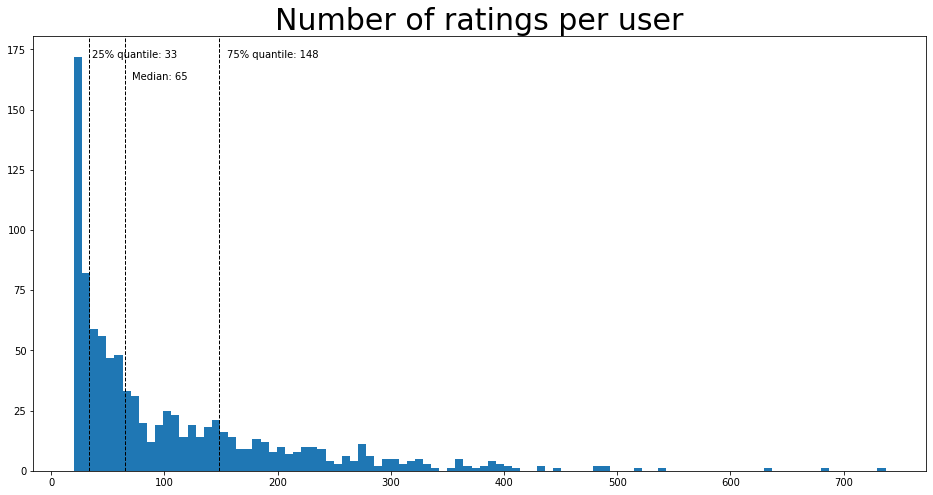

In [4]:
items_per_user=df.groupby(['user']).count()['rating']

plt.figure(figsize=(16,8))
plt.hist(items_per_user, bins=100)

# Let's add median
t=items_per_user.median()
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.text(t*1.1, plt.ylim()[1]*0.9, 'Median: {:.0f}'.format(t))

# Let's add also some percentiles
t=items_per_user.quantile(0.25)
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.text(t*1.1, plt.ylim()[1]*0.95, '25% quantile: {:.0f}'.format(t))

t=items_per_user.quantile(0.75)
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.text(t*1.05, plt.ylim()[1]*0.95, '75% quantile: {:.0f}'.format(t))

plt.title('Number of ratings per user', fontsize=30)
plt.show()

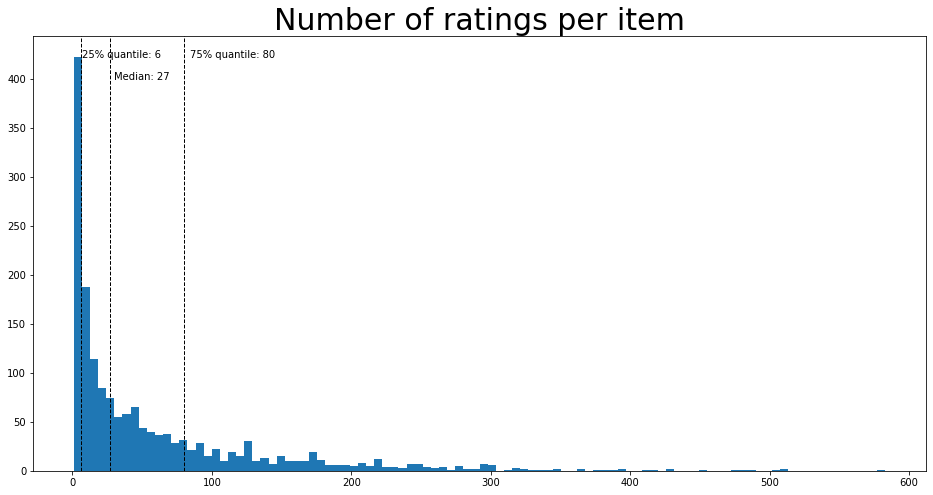

In [5]:
users_per_item=df.groupby(['item']).count()['rating']

plt.figure(figsize=(16,8))
plt.hist(users_per_item, bins=100)

# Let's add median
t=users_per_item.median()
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.text(t*1.1, plt.ylim()[1]*0.9, 'Median: {:.0f}'.format(t))

# Let's add also some percentiles
t=users_per_item.quantile(0.25)
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.text(t*1.1, plt.ylim()[1]*0.95, '25% quantile: {:.0f}'.format(t))

t=users_per_item.quantile(0.75)
plt.axvline(t, color='k', linestyle='dashed', linewidth=1)
plt.text(t*1.05, plt.ylim()[1]*0.95, '75% quantile: {:.0f}'.format(t))

plt.title('Number of ratings per item', fontsize=30)
plt.show()

In [6]:
df.groupby(['rating']).count()['user']/len(df)

rating
1    0.06110
2    0.11370
3    0.27145
4    0.34174
5    0.21201
Name: user, dtype: float64

# Item attributes

In [7]:
genres = pd.read_csv('./Datasets/ml-100k/u.genre', sep='|', header=None,
                     encoding='latin-1')
genres=dict(zip(genres[1], genres[0]))

In [8]:
genres

{0: 'unknown',
 1: 'Action',
 2: 'Adventure',
 3: 'Animation',
 4: "Children's",
 5: 'Comedy',
 6: 'Crime',
 7: 'Documentary',
 8: 'Drama',
 9: 'Fantasy',
 10: 'Film-Noir',
 11: 'Horror',
 12: 'Musical',
 13: 'Mystery',
 14: 'Romance',
 15: 'Sci-Fi',
 16: 'Thriller',
 17: 'War',
 18: 'Western'}

In [9]:
movies = pd.read_csv('./Datasets/ml-100k/u.item', sep='|', encoding='latin-1', header=None)

In [10]:
movies[:3]

0                  1            2   3   \
0   1   Toy Story (1995)  01-Jan-1995 NaN   
1   2   GoldenEye (1995)  01-Jan-1995 NaN   
2   3  Four Rooms (1995)  01-Jan-1995 NaN   

                                                  4   5   6   7   8   9   ...  \
0  http://us.imdb.com/M/title-exact?Toy%20Story%2...   0   0   0   1   1  ...   
1  http://us.imdb.com/M/title-exact?GoldenEye%20(...   0   1   1   0   0  ...   
2  http://us.imdb.com/M/title-exact?Four%20Rooms%...   0   0   0   0   0  ...   

   14  15  16  17  18  19  20  21  22  23  
0   0   0   0   0   0   0   0   0   0   0  
1   0   0   0   0   0   0   0   1   0   0  
2   0   0   0   0   0   0   0   1   0   0  

[3 rows x 24 columns]

In [11]:
for i in range(19):
    movies[i+5]=movies[i+5].apply(lambda x: genres[i] if x==1 else '')

In [12]:
movies['genre']=movies.iloc[:, 5:].apply(lambda x: ', '.join(x[x!='']), axis = 1)

In [13]:
movies=movies[[0,1,'genre']]
movies.columns=['id', 'title', 'genres']

In [14]:
movies.to_csv('./Datasets/ml-100k/movies.csv', index=False)
movies[:5]

id              title                         genres
0   1   Toy Story (1995)  Animation, Children's, Comedy
1   2   GoldenEye (1995)    Action, Adventure, Thriller
2   3  Four Rooms (1995)                       Thriller
3   4  Get Shorty (1995)          Action, Comedy, Drama
4   5     Copycat (1995)         Crime, Drama, Thriller

# Toy example

In [15]:
os.makedirs('./Datasets/toy-example/', exist_ok = True)

In [16]:
toy_train=pd.DataFrame([[0,0,3,0], [0,10,4,0], [0,40,5,0], [0,70,4,0],
              [10,10,1,0], [10,20,2,0], [10,30,3,0],
              [20,30,5,0], [20,50,3,0], [20,60,4,0]])
toy_test=pd.DataFrame([[0,60,3,0],
              [10,40,5,0],
              [20,0,5,0], [20,20,4,0], [20,70,2,0]])

toy_train.to_csv('./Datasets/toy-example/train.csv', sep='\t', header=None, index=False)
toy_test.to_csv('./Datasets/toy-example/test.csv', sep='\t', header=None, index=False)